In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib_venn import venn3
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [82]:
data= pd.read_csv(r"/content/pca_transformed.csv")

In [83]:
X = data.drop('num', axis=1)
y = data['num']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
#Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_importances = rf_model.feature_importances_
rf_features = X.columns
rf_indices = rf_importances.argsort()[::-1]

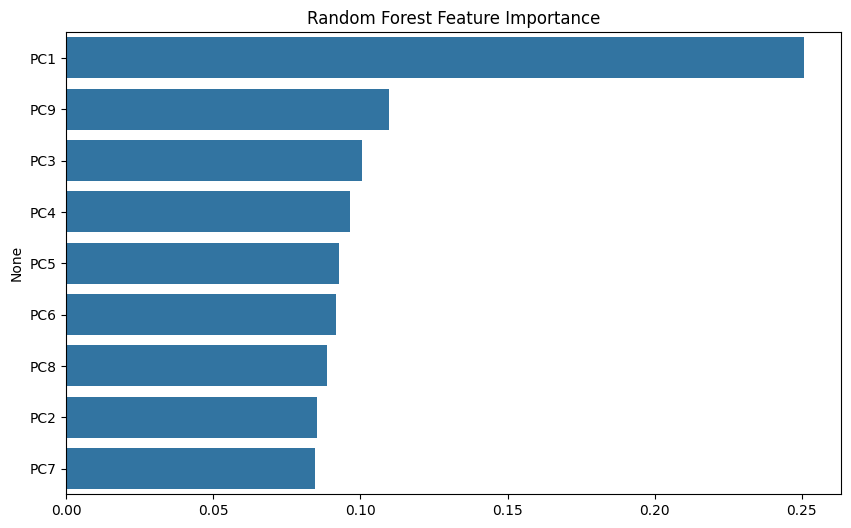

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances[rf_indices], y=rf_features[rf_indices])
plt.title('Random Forest Feature Importance')
plt.show()

In [86]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

xgb_importances = xgb_model.feature_importances_
xgb_features = X.columns
xgb_indices = xgb_importances.argsort()[::-1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:06:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


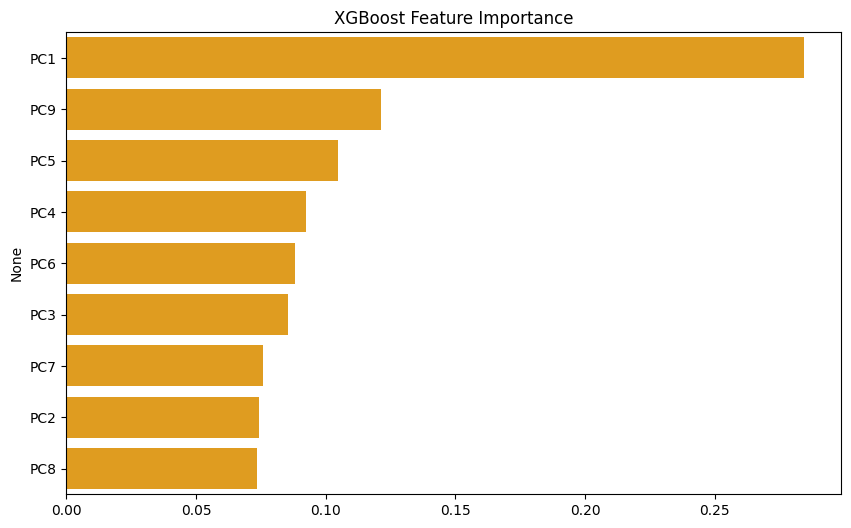

In [87]:
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances[xgb_indices], y=xgb_features[xgb_indices], color='orange')
plt.title('XGBoost Feature Importance')
plt.show()

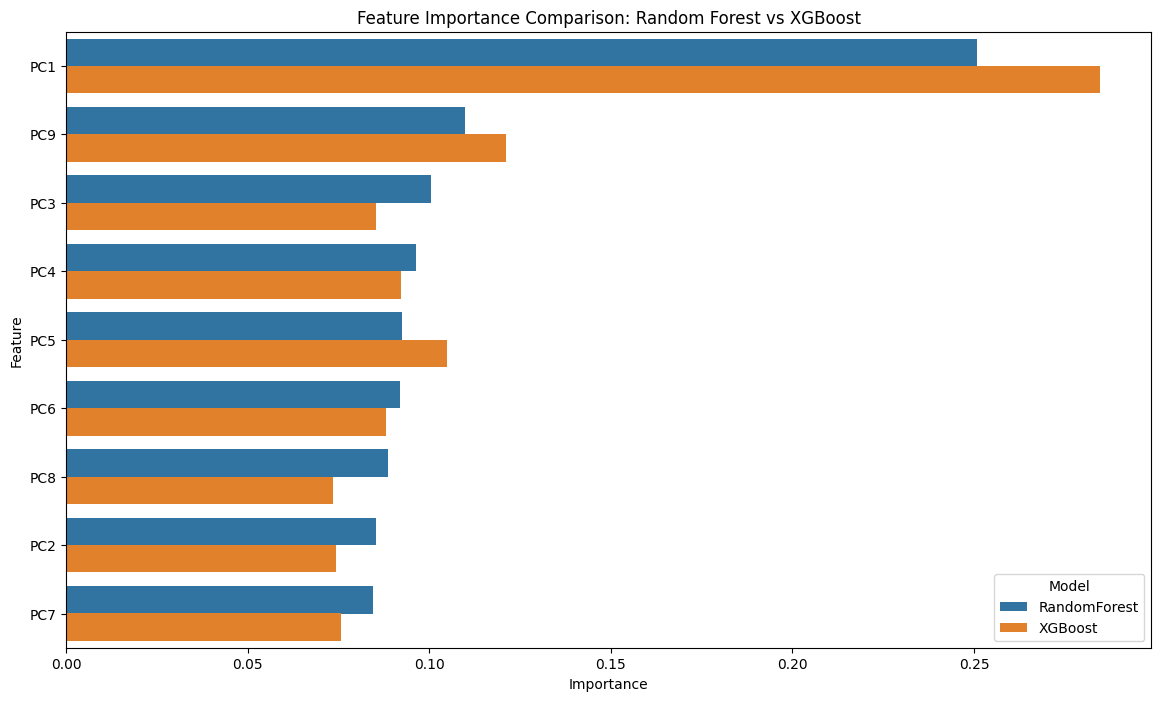

In [88]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RandomForest': rf_importances,
    'XGBoost': xgb_importances
}).sort_values('RandomForest', ascending=False)

importance_df_melted = importance_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(14, 8))
sns.barplot(data=importance_df_melted, x='Importance', y='Feature', hue='Model')
plt.title("Feature Importance Comparison: Random Forest vs XGBoost")
plt.show()


In [89]:
#  RFE (with RF)
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_features = X.columns[rfe_selector.support_]
print("Top features selected by RFE:")
print(list(rfe_features))

Top features selected by RFE:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=9. There will be no feature selection and all features will be kept.
  warnings.warn(


In [90]:
# Chi-Square Test
X_chi2 = X.apply(lambda x: x - x.min() if x.min() < 0 else x)
chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X_chi2, y)
chi2_features = X.columns[chi2_selector.get_support()]


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


In [91]:
print("Top features selected by Chi-Square Test:")
print(list(chi2_features))

Top features selected by Chi-Square Test:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']


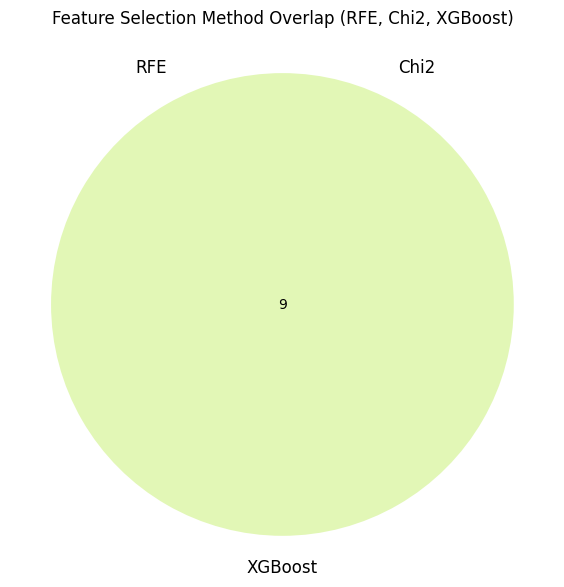

In [96]:
# Venn Diagram of Feature Selection Methods
rfe_set = set(rfe_features)
chi2_set = set(chi2_features)
xgb_set = set(X.columns[xgb_importances > 0.01])  # threshold can be tuned

plt.figure(figsize=(8, 6))
venn3(
    [rfe_set, chi2_set, xgb_set],
    set_labels=('RFE', 'Chi2', 'XGBoost'),
    set_colors=('skyblue', 'lightgreen', 'orange'),
    alpha=0.7
)
plt.title("Feature Selection Method Overlap (RFE, Chi2, XGBoost)")
plt.tight_layout()
plt.show()

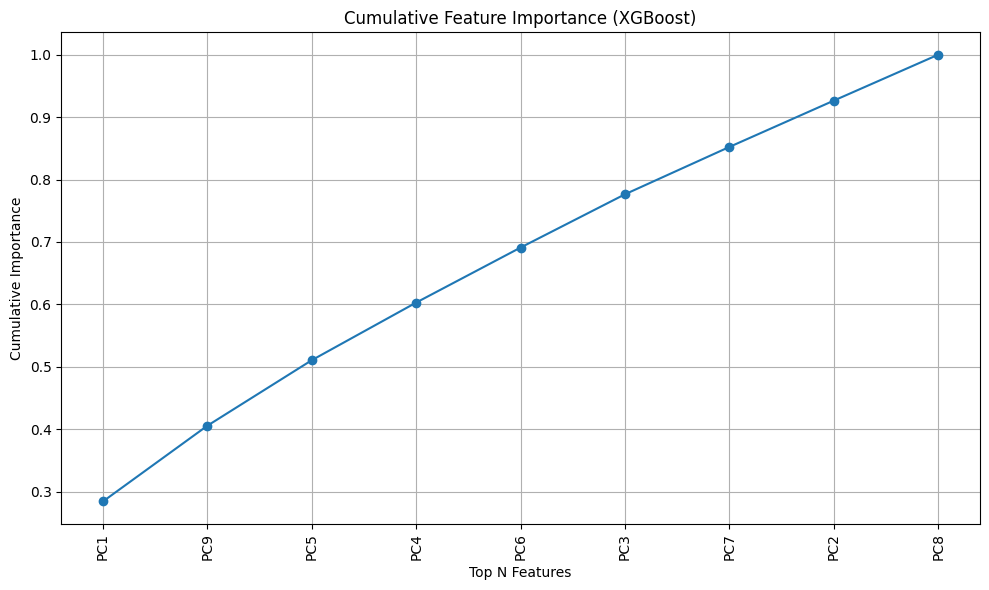

In [93]:
#  Cumulative Feature Importance Plot (XGBoost)
sorted_idx = np.argsort(xgb_importances)[::-1]
cum_importance = np.cumsum(xgb_importances[sorted_idx])
features_sorted = X.columns[sorted_idx]

plt.figure(figsize=(10, 6))
plt.plot(range(len(cum_importance)), cum_importance, marker='o')
plt.xticks(ticks=range(len(features_sorted)), labels=features_sorted, rotation=90)
plt.xlabel("Top N Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
#Final Feature Selection
final_features = list(set(rfe_features) | set(chi2_features) | set(xgb_set))
X_selected = X[final_features]
X_selected.to_csv("reduced_dataset.csv", index=False)
